In [75]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter, AutoDateLocator

In [21]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [23]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [24]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
print(Base.classes.keys())


['measurement', 'station']


In [25]:
# View all of the classes that automap found
class_names = Base.classes.keys()
for class_name in class_names:
    print(class_name)

measurement
station


In [26]:
# Save references to each table
tables = {}
for table_name, table_class in Base.classes.items():
    tables[table_name] = table_class

measurement_table = tables['measurement']
station_table = tables['station']

In [27]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [49]:
# Find the most recent date in the data set.
max_date = session.query(func.max(measurement_table.date)).scalar()
max_date_obj= dt.strptime(max_date, '%Y-%m-%d')
max_date_obj

datetime.datetime(2017, 8, 23, 0, 0)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

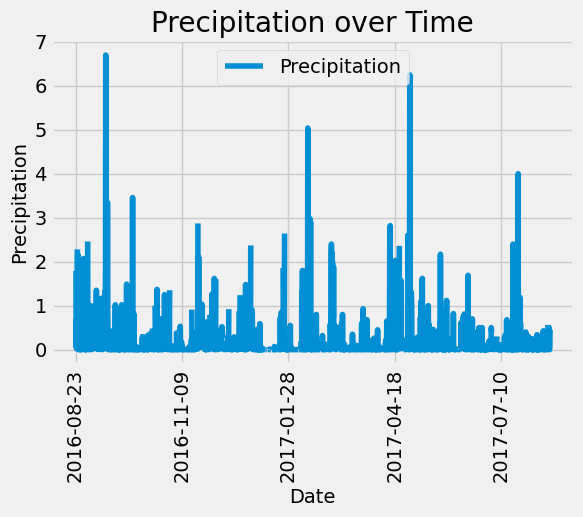

In [114]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
start_date_obj = session.query(func.date(max_date_obj, '-1 year')).scalar()

# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement_table.date, measurement_table.prcp) \
    .filter(measurement_table.date >= start_date_obj) \
    .filter(measurement_table.date <= max_date_obj)
results = query.all()
# for date, precipitation in results:
#     print("Date:", date, "Precipitation:", precipitation)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ['Date', 'Precipitation']
prcp = pd.DataFrame(results, columns=column_names)
prcp.head()

# Sort the dataframe by date
prcp_sorted = prcp.sort_values('Date')
prcp_sorted

# Use Pandas Plotting with Matplotlib to plot the data
prcp_sorted.plot(x='Date', y='Precipitation', kind='line', figsize=(6,4))
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation over Time')
plt.xticks(rotation='vertical')




In [93]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prcp_sorted['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [94]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station_table.id)).scalar()
total_stations

9

In [97]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
observation_counts = session.query(measurement_table.station, func.count(measurement_table.id)) \
                            .group_by(measurement_table.station) \
                            .order_by(func.count(measurement_table.id).desc()) \
                            .all()
for station, count in observation_counts:
    print( station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [102]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(measurement_table.tobs),
                       func.max(measurement_table.tobs),
                       func.avg(measurement_table.tobs)) \
                .filter(measurement_table.station == "USC00519281") \
                .one()

# Print the results
print("Lowest Temperature:", result[0])
print("Highest Temperature:", result[1])
print("Average Temperature:", result[2])

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


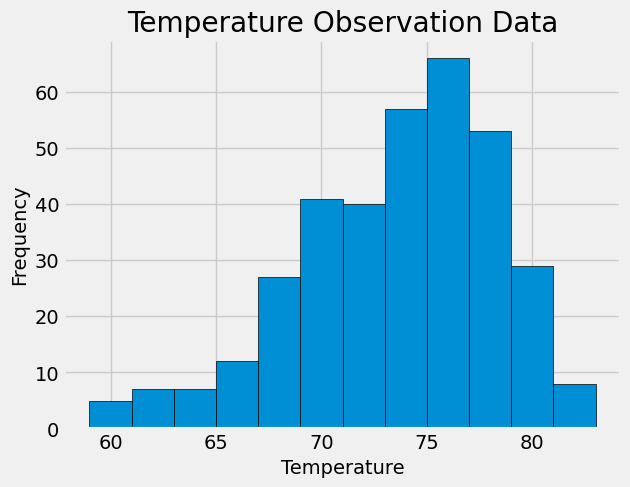

In [106]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement_table.tobs) \
    .filter(measurement_table.date >= start_date_obj) \
    .filter(measurement_table.date <= max_date_obj)\
    .filter(measurement_table.station == "USC00519281")

temperature_data = [result[0] for result in query]

plt.hist(temperature_data, bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data')
plt.show()

# Close Session

In [108]:
# Close Session
session.close()